In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
import tensorflow as tf 
from keras.models import Sequential 
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50

# Read the Images

In [2]:
datadir = "./train"
categories = ['Closed_Eyes', 'Open_Eyes']

for category in categories:
    catdir = datadir + "/" + category
    globals()[f"{category}_files"] = [catdir+"/"+filename for filename in os.listdir(catdir)]

In [3]:
print(f"Data with eyes closed: {len(Closed_Eyes_files)}")
print(f"Data with eyes open: {len(Open_Eyes_files)}")

Data with eyes closed: 2000
Data with eyes open: 2000


(83, 83)


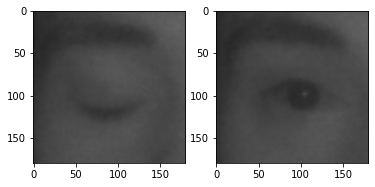

In [4]:
fig, ax = plt.subplots(1,2)
img_arr = cv2.imread(Closed_Eyes_files[0], cv2.IMREAD_GRAYSCALE)
img_arr_rgb = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2RGB)
new_arr = cv2.resize(img_arr_rgb, (180,180))
ax[0].imshow(new_arr);
img_arr = cv2.imread(Open_Eyes_files[0], cv2.IMREAD_GRAYSCALE)
img_arr_rgb = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2RGB)
new_arr = cv2.resize(img_arr_rgb, (180,180))
ax[1].imshow(new_arr);
print(img_arr.shape)

(86, 86)


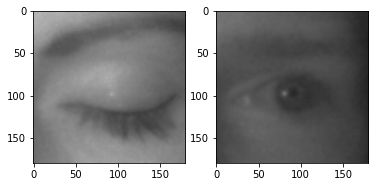

In [5]:
fig, ax = plt.subplots(1,2)
img_arr = cv2.imread(Closed_Eyes_files[1543], cv2.IMREAD_GRAYSCALE)
img_arr_rgb = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2RGB)
new_arr = cv2.resize(img_arr_rgb, (180,180))
ax[0].imshow(new_arr);
img_arr = cv2.imread(Open_Eyes_files[1543], cv2.IMREAD_GRAYSCALE)
img_arr_rgb = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2RGB)
new_arr = cv2.resize(img_arr_rgb, (180,180))
ax[1].imshow(new_arr);
print(img_arr.shape)

In [6]:
max_shape = 0
for category in os.listdir("./train"):    
    for i in globals()[f"{category}_files"]:
        img_arr = cv2.imread(i)
        compare_shape = img_arr.shape[0]
        if compare_shape > max_shape:
            max_shape = compare_shape
        
print(f"Max shape of image in the dataset: {max_shape}")

Max shape of image in the dataset: 180


In [7]:
def create_data_pairs(max_shape: int = 180, shuffle:bool = True):
    training_data = []
    for category in os.listdir("./train"): 
        for img_loc in globals()[f"{category}_files"]:
            img_array = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
            img_rgb = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
            new_array = cv2.resize(img_rgb, (max_shape, max_shape))
            training_data.append([new_array, category])
    print(f"Number of data points: {len(training_data)}")
    if shuffle:
        random.shuffle(training_data)
    return training_data

In [8]:
data = create_data_pairs(max_shape= 224)

Number of data points: 4000


In [9]:
X,y = [], []
for inputs, outputs in data:
    X.append(inputs)
    if outputs == "Closed_Eyes":
        y.append(0)
    else:
        y.append(1)

X = np.array(X) / 255
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2, random_state= 42)
print(f"Number of training_data: {len(X_train)}, shape of X_train: {X_train.shape}")
print(f"Number of test_data: {len(X_test)}, shape of X_test: {X_test.shape}")

Number of training_data: 3200, shape of X_train: (3200, 224, 224, 3)
Number of test_data: 800, shape of X_test: (800, 224, 224, 3)


# Building Model

In [23]:
resnet = ResNet50(input_shape= [224,224,3], weights= 'imagenet', include_top= False)
for layer in resnet.layers:
    layer.trainable = False
    
resnet_model = Sequential()

resnet_model.add(resnet)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation= 'relu'))
resnet_model.add(Dense(2, activation= 'softmax'))

resnet_model.compile(optimizer=Adam(learning_rate= 0.0001), loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

In [24]:
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 512)               51380736  
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 74,969,474
Trainable params: 51,381,762
Non-trainable params: 23,587,712
_________________________________________________________________


In [20]:
# kfold = KFold(n_splits= 3,shuffle=False)
# for epoch in range(2):
#     epoch += 1
#     fold_no = 1
#     for train_idx, val_idx in kfold.split(X_train, y_train):
#         print("Fetching data for cross-validation")
#         train_X = X_train[train_idx]
#         train_y = y_train[train_idx]
#         val_X = X_train[val_idx]
#         val_y = y_train[val_idx]
        
#         print(f"Epoch: {epoch}, Fold: {fold_no}")
#         resnet_model.fit(x= train_X, y= train_y, batch_size= 32, validation_data= (val_X, val_y))
    
#         fold_no += 1

In [21]:
# resnet_model.evaluate(X_test, y_test)

In [25]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = 'bestResNet.h5',
    save_weights_only = False,
    monitor = 'val_accuracy',
    mode = 'min',
    save_best_only = True,
    verbose = 1,
)
resnet_model.fit(X_train, y_train, validation_split= 0.2, epochs=5, batch_size= 32, callbacks= callback)

Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 1.0999 - accuracy: 0.5684
Epoch 1: val_loss improved from inf to 0.53023, saving model to bestResNet.h5
80/80 [==============================] - 319s 4s/step - loss: 1.0999 - accuracy: 0.5684 - val_loss: 0.5302 - val_accuracy: 0.7250
Epoch 2/5
80/80 [==============================] - ETA: 0s - loss: 0.5393 - accuracy: 0.7152
Epoch 2: val_loss improved from 0.53023 to 0.47060, saving model to bestResNet.h5
80/80 [==============================] - 310s 4s/step - loss: 0.5393 - accuracy: 0.7152 - val_loss: 0.4706 - val_accuracy: 0.7266
Epoch 3/5
80/80 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.7203
Epoch 3: val_loss improved from 0.47060 to 0.44611, saving model to bestResNet.h5
80/80 [==============================] - 316s 4s/step - loss: 0.5222 - accuracy: 0.7203 - val_loss: 0.4461 - val_accuracy: 0.9187
Epoch 4/5
80/80 [==============================] - ETA: 0s - loss: 0.4574 - accuracy: 0.7

In [26]:
resnet_model.evaluate(X_test, y_test)

25/25 [==============================] - 77s 3s/step - loss: 0.3785 - accuracy: 0.8575


[0.37851011753082275, 0.8575000166893005]

In [27]:
from keras.models import load_model

best_model = load_model("bestResNet.h5")
best_model.evaluate(X_test, y_test)

25/25 [==============================] - 86s 3s/step - loss: 0.3785 - accuracy: 0.8575


[0.37851011753082275, 0.8575000166893005]